In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd

# Load data
data = pd.read_csv('xydata_2021winter.csv')

# Define target and features
target_columns_clusters = [f"Cluster{i}" for i in range(6)]
selected_features_updated = [
    "Time_Period", "Stn Press (kPa)", "Dew Point Temp (°C)", "Rel Hum (%)",
    "Visibility (km)", "Temp (°C)", "Wind Dir (10s deg)", "Wind Spd (km/h)",
    "C4D-1HA", "C4D-2HA", "C3D-1HA", "C5D-1HA"
]

X = data[selected_features_updated]
y = data[target_columns_clusters]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Step 1: Fine-Tune scale_pos_weight per Cluster
param_grid_xgb_weighted = {
    'classifier__estimator__n_estimators': [100, 200],
    'classifier__estimator__max_depth': [3, 5],
    'classifier__estimator__learning_rate': [0.1],
    'classifier__estimator__subsample': [0.8],
    'classifier__estimator__scale_pos_weight': [1, 5, 10, 20]  # Adjust for imbalanced classes
}

# Initialize XGBoost in a MultiOutputClassifier pipeline
pipe_xgb_weighted = Pipeline([
    ('classifier', MultiOutputClassifier(
        XGBClassifier(eval_metric="logloss", random_state=42)
    ))
])

grid_xgb_weighted = GridSearchCV(
    pipe_xgb_weighted,
    param_grid_xgb_weighted,
    cv=5,
    scoring="f1_weighted",
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

grid_xgb_weighted.fit(X_train, y_train)

# Evaluate performance
print("Best parameters with tuned scale_pos_weight:\n", grid_xgb_weighted.best_params_)
y_test_pred_weighted = grid_xgb_weighted.best_estimator_.predict(X_test)
test_f1_score_weighted = f1_score(y_test, y_test_pred_weighted, average='weighted')
print(f"Test-set F1-score after tuning scale_pos_weight: {test_f1_score_weighted:.2f}")
print(classification_report(y_test, y_test_pred_weighted, zero_division=0))

# Step 2: Use Feature Importance to Refine Features
best_model = grid_xgb_weighted.best_estimator_.named_steps['classifier']
feature_importances = pd.DataFrame(index=selected_features_updated)

# Calculate average feature importance across all clusters
for idx, estimator in enumerate(best_model.estimators_):
    cluster_importance = pd.Series(estimator.feature_importances_, index=selected_features_updated)
    feature_importances[f'Cluster{idx}'] = cluster_importance

feature_importances['Mean_Importance'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values(by='Mean_Importance', ascending=False)

print("Feature importances:\n", feature_importances)

# Select top N features based on mean importance
top_features = feature_importances.head(10).index.tolist()
print(f"Top features selected: {top_features}")

# Retrain the model with top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

grid_xgb_weighted.fit(X_train_top, y_train)

# Evaluate performance with top features
y_test_pred_top = grid_xgb_weighted.best_estimator_.predict(X_test_top)
test_f1_score_top = f1_score(y_test, y_test_pred_top, average='weighted')
print(f"Test-set F1-score with top features: {test_f1_score_top:.2f}")
print(classification_report(y_test, y_test_pred_top, zero_division=0))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters with tuned scale_pos_weight:
 {'classifier__estimator__learning_rate': 0.1, 'classifier__estimator__max_depth': 3, 'classifier__estimator__n_estimators': 100, 'classifier__estimator__scale_pos_weight': 10, 'classifier__estimator__subsample': 0.8}
Test-set F1-score after tuning scale_pos_weight: 0.69
              precision    recall  f1-score   support

           0       0.45      0.82      0.58        55
           1       0.44      0.73      0.55        48
           2       0.59      0.91      0.71        75
           3       0.59      0.89      0.71        76
           4       0.66      0.90      0.76        73
           5       0.66      0.90      0.76        93

   micro avg       0.57      0.87      0.69       420
   macro avg       0.56      0.86      0.68       420
weighted avg       0.58      0.87      0.69       420
 samples avg       0.50      0.72      0.56       420

Feature importances:
    

In [4]:
# Extend feature set to include historical accident data for Clusters 0, 1, and 2
selected_features_updated_with_history = [
    "Time_Period", "Stn Press (kPa)", "Dew Point Temp (°C)", "Rel Hum (%)",
    "Visibility (km)", "Temp (°C)", "Wind Dir (10s deg)", "Wind Spd (km/h)",
    # Existing historical features
    "C4D-1HA", "C4D-2HA", "C3D-1HA", "C5D-1HA",
    # Newly included historical features for Clusters 0, 1, and 2
    "C0D-1HA", "C0D-2HA", "C1D-1HA", "C1D-2HA", "C2D-1HA", "C2D-2HA"
]

X = data[selected_features_updated_with_history]

# Redefine train-test split with the updated feature set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Retrain XGBoost with the expanded feature set
grid_xgb_with_history = GridSearchCV(
    pipe_xgb_weighted,
    param_grid_xgb_weighted,
    cv=5,
    scoring="f1_weighted",
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

grid_xgb_with_history.fit(X_train, y_train)

# Evaluate performance
print("Best parameters with historical features:\n", grid_xgb_with_history.best_params_)
y_test_pred_with_history = grid_xgb_with_history.best_estimator_.predict(X_test)
test_f1_score_with_history = f1_score(y_test, y_test_pred_with_history, average='weighted')
print(f"Test-set F1-score after adding historical features: {test_f1_score_with_history:.2f}")
print(classification_report(y_test, y_test_pred_with_history, zero_division=0))


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters with historical features:
 {'classifier__estimator__learning_rate': 0.1, 'classifier__estimator__max_depth': 3, 'classifier__estimator__n_estimators': 100, 'classifier__estimator__scale_pos_weight': 20, 'classifier__estimator__subsample': 0.8}
Test-set F1-score after adding historical features: 0.69
              precision    recall  f1-score   support

           0       0.44      0.84      0.58        55
           1       0.43      0.75      0.55        48
           2       0.55      0.92      0.69        75
           3       0.57      0.91      0.70        76
           4       0.61      0.90      0.73        73
           5       0.65      0.94      0.77        93

   micro avg       0.55      0.89      0.68       420
   macro avg       0.54      0.88      0.67       420
weighted avg       0.56      0.89      0.69       420
 samples avg       0.50      0.73      0.57       420



In [5]:
# Retrieve key metrics from GridSearchCV
best_train_score = max(grid_xgb_with_history.cv_results_['mean_train_score'])
best_val_score = grid_xgb_with_history.best_score_

# Display the metrics
print(f"Best cross-validation train score: {best_train_score:.2f}")
print(f"Best cross-validation validation score: {best_val_score:.2f}")

# Evaluate on the test set
y_test_pred_with_history = grid_xgb_with_history.best_estimator_.predict(X_test)
test_f1_score_with_history = f1_score(y_test, y_test_pred_with_history, average='weighted')
print(f"Test-set F1-score: {test_f1_score_with_history:.2f}")


Best cross-validation train score: 1.00
Best cross-validation validation score: 0.67
Test-set F1-score: 0.69


/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation Analysis:
                      Cluster0  Cluster2  Cluster3
Time_Period         -0.256427 -0.271768 -0.262450
C0D-1HA              0.102119  0.203636  0.096163
C0D-2HA              0.145887  0.157843  0.114186
C0D-3HA              0.115766  0.160195  0.102874
C0D-4HA              0.117636  0.236054  0.142907
C1D-1HA              0.092170  0.147843  0.150310
C1D-2HA              0.117980  0.104676  0.098038
C1D-3HA              0.060632  0.131573  0.059890
C1D-4HA              0.086617  0.194291  0.066830
C2D-1HA              0.143218  0.219685  0.220932
C2D-2HA              0.103457  0.219704  0.165667
C2D-3HA              0.069791  0.185348  0.144704
C2D-4HA              0.129859  0.133764  0.109447
C3D-1HA              0.112735  0.229503  0.144669
C3D-2HA              0.172750  0.155308  0.095743
C3D-3HA              0.139634  0.154227  0.097663
C3D-4HA              0.127417  0.183189  0.123331
C4D-1HA              0.192946  0.225642  0.211837
C4D-2HA              0.1597

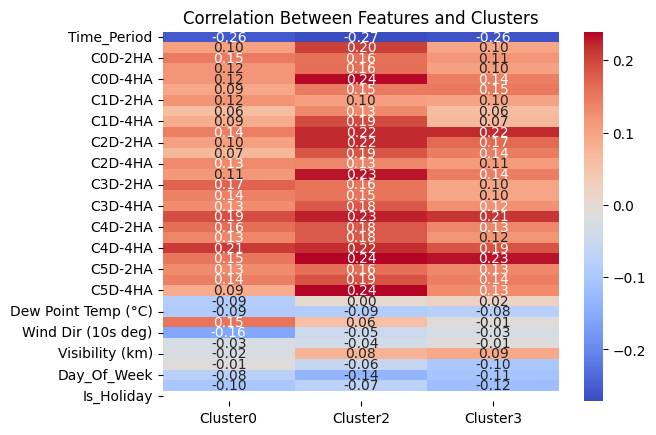

Mutual Information Scores:
                      Cluster0  Cluster2  Cluster3
Time_Period          0.031069  0.087319  0.072761
C0D-1HA              0.002624  0.006782  0.000000
C0D-2HA              0.021941  0.033246  0.000000
C0D-3HA              0.009528  0.007057  0.034077
C0D-4HA              0.019987  0.021983  0.013961
C1D-1HA              0.025635  0.032339  0.059171
C1D-2HA              0.012367  0.015917  0.012151
C1D-3HA              0.028491  0.000000  0.026515
C1D-4HA              0.025899  0.040624  0.036273
C2D-1HA              0.011223  0.009122  0.021401
C2D-2HA              0.032404  0.039711  0.009673
C2D-3HA              0.015638  0.037723  0.015531
C2D-4HA              0.007304  0.038595  0.046797
C3D-1HA              0.026972  0.025412  0.000000
C3D-2HA              0.042031  0.000000  0.000000
C3D-3HA              0.029633  0.014543  0.006134
C3D-4HA              0.000000  0.018537  0.000000
C4D-1HA              0.000000  0.001470  0.027243
C4D-2HA              0

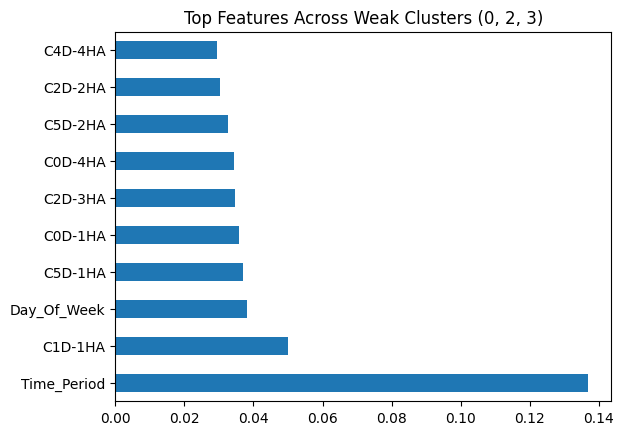

In [6]:
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier

# Use the original feature set
original_features = data.drop(columns=["Date", "Total_Accidents"] + target_columns_clusters)
X_original = original_features
y_clusters = y  # Cluster targets

# Analyze Correlations
correlations = {}
for cluster in ["Cluster0", "Cluster2", "Cluster3"]:
    correlations[cluster] = X_original.corrwith(y_clusters[cluster])
    
correlation_df = pd.DataFrame(correlations)
print("Correlation Analysis:\n", correlation_df)

# Visualize Correlation Heatmap
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Between Features and Clusters")
plt.show()

# Compute Mutual Information
mutual_info_scores = {}
for cluster in ["Cluster0", "Cluster2", "Cluster3"]:
    mutual_info_scores[cluster] = mutual_info_classif(X_original, y_clusters[cluster], random_state=42)

mutual_info_df = pd.DataFrame(mutual_info_scores, index=X_original.columns)
print("Mutual Information Scores:\n", mutual_info_df)

# Train XGBoost Models for Feature Importance
feature_importances = {}
for cluster in ["Cluster0", "Cluster2", "Cluster3"]:
    model = XGBClassifier(eval_metric="logloss", random_state=42)
    model.fit(X_original, y_clusters[cluster])
    feature_importances[cluster] = model.feature_importances_

feature_importance_df = pd.DataFrame(feature_importances, index=X_original.columns)
print("Feature Importances:\n", feature_importance_df)

# Visualize Feature Importance
feature_importance_df.mean(axis=1).sort_values(ascending=False).head(10).plot(
    kind="barh", title="Top Features Across Weak Clusters (0, 2, 3)"
)
plt.show()
